In [6]:
import torch, tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

def Accuracy(TRUTH, PREDICTION, BATCH_SIZE):
    return (TRUTH==PREDICTION).sum().item()/BATCH_SIZE

# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

GPU State: cuda:0


In [7]:
# Data
valid_size=0.2
shuffle = True
random_seed = 100
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
valSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

num_train = len(trainSet)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

In [8]:
# Model
class Shallow_Net(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*676, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)

class Shallow_Net_w_MaxPooling(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net_w_MaxPooling, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*625, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)

class Shallow_Net_w_MaxPooling_w_dropout(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net_w_MaxPooling_w_dropout, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 1),
            torch.nn.Dropout(0.25),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*625, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)
net_1 = Shallow_Net().to(device)
net_2 = Shallow_Net_w_MaxPooling().to(device)
net_3 = Shallow_Net_w_MaxPooling_w_dropout().to(device)
print(net_1)
print(net_2)
print(net_3)

Shallow_Net(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=13520, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)
Shallow_Net_w_MaxPooling(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=12500, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)
Shallow_Net_w_MaxPooling_w_dropout(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0

In [9]:
def train_fn(epochs, lr, optimizer_name, net, name_of_net):
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
    else : 
        print("Error, please input 'SGD' or Adam.")
    # Train
    epoch_loss = []
    epoch_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_loss_val = 0.0
        running_acc_val = 0.0
        
        for times, data in enumerate(trainLoader):
            net.train()
#             print("Training")
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            running_acc += Accuracy(labels, predicted, trainLoader.batch_size)
#             if times % 100 == 99 or times+1 == len(trainLoader):
#                 print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/2000))
        with torch.no_grad():
            net.eval()
#             print("Validating.")
            for times_val, data_val in enumerate(valLoader):
                inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
        #         inputs = inputs.view(inputs.shape[0], -1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Foward + backward + optimize
                outputs_val = net(inputs_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                loss_val = criterion(outputs_val, labels_val)
#                     loss_val.backward()
#                     optimizer.step()

                # Print statistics
                running_loss_val += loss_val.item()
                running_acc_val += Accuracy(labels_val, predicted_val, valLoader.batch_size)
            _epoch_val_loss = running_loss_val/len(valLoader)
            _epoch_val_acc = running_acc_val/len(valLoader)
            epoch_val_loss.append(_epoch_val_loss)
            epoch_val_acc.append(_epoch_val_acc)
                
        _epoch_loss = running_loss/len(trainLoader)
        _epoch_acc = running_acc/len(trainLoader)
        epoch_loss.append(_epoch_loss)
        epoch_acc.append(_epoch_acc)
        print("Epoch: {0}, loss: {1:.3f}, acc: {2:.3f}, val_loss: {3:.3f}, val_acc: {4:.3f}".format(epoch+1, _epoch_loss, _epoch_acc, _epoch_val_loss, _epoch_val_acc))
    print('Training Finished.')
    
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        net.eval()
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    #             print(class_correct)
    #             print(class_total)

    for i in range(10):
        print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))
    acc = (100*correct / total)
    x = np.linspace(1, epochs, num = epochs)
    plt.plot(x, epoch_acc, label='acc')
    plt.plot(x, epoch_loss, label='loss')
    plt.plot(x, epoch_val_loss, label='val_loss')
    plt.plot(x, epoch_val_acc, label='val_acc')
    plt.xlabel('epochs')
    plt.ylabel('acc/loss')
    plt.legend(loc="upper right")
    plt.savefig("mnist_cnn_"+optimizer_name+str(name_of_net)+"_ce_shallow_"+str(int(acc))+".png")
    plt.show()

Epoch: 1, loss: 1.681, acc: 0.781, val_loss: 1.588, val_acc: 0.871
Epoch: 2, loss: 1.547, acc: 0.915, val_loss: 1.497, val_acc: 0.963
Epoch: 3, loss: 1.487, acc: 0.975, val_loss: 1.492, val_acc: 0.967
Epoch: 4, loss: 1.482, acc: 0.979, val_loss: 1.488, val_acc: 0.971
Epoch: 5, loss: 1.480, acc: 0.981, val_loss: 1.485, val_acc: 0.973
Epoch: 6, loss: 1.478, acc: 0.984, val_loss: 1.484, val_acc: 0.975
Epoch: 7, loss: 1.476, acc: 0.985, val_loss: 1.485, val_acc: 0.974
Epoch: 8, loss: 1.475, acc: 0.987, val_loss: 1.484, val_acc: 0.975
Epoch: 9, loss: 1.473, acc: 0.988, val_loss: 1.484, val_acc: 0.975
Epoch: 10, loss: 1.472, acc: 0.989, val_loss: 1.485, val_acc: 0.974
Epoch: 11, loss: 1.472, acc: 0.990, val_loss: 1.488, val_acc: 0.971
Epoch: 12, loss: 1.471, acc: 0.990, val_loss: 1.483, val_acc: 0.975
Epoch: 13, loss: 1.470, acc: 0.991, val_loss: 1.482, val_acc: 0.977
Epoch: 14, loss: 1.470, acc: 0.991, val_loss: 1.482, val_acc: 0.977
Epoch: 15, loss: 1.469, acc: 0.992, val_loss: 1.485, val_

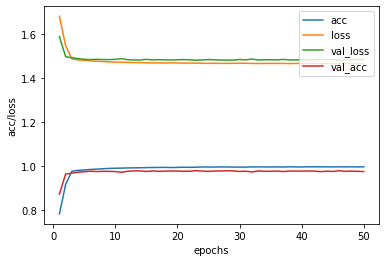

In [8]:
train_fn(50, 0.01, "Adam", net_1, "_without_maxpooling_")

Epoch: 1, loss: 1.715, acc: 0.757, val_loss: 1.628, val_acc: 0.831
Epoch: 2, loss: 1.622, acc: 0.840, val_loss: 1.626, val_acc: 0.833
Epoch: 3, loss: 1.616, acc: 0.845, val_loss: 1.615, val_acc: 0.843
Epoch: 4, loss: 1.613, acc: 0.848, val_loss: 1.619, val_acc: 0.840
Epoch: 5, loss: 1.609, acc: 0.852, val_loss: 1.608, val_acc: 0.850
Epoch: 6, loss: 1.606, acc: 0.855, val_loss: 1.606, val_acc: 0.853
Epoch: 7, loss: 1.603, acc: 0.859, val_loss: 1.604, val_acc: 0.855
Epoch: 8, loss: 1.599, acc: 0.862, val_loss: 1.604, val_acc: 0.856
Epoch: 9, loss: 1.595, acc: 0.867, val_loss: 1.596, val_acc: 0.862
Epoch: 10, loss: 1.591, acc: 0.871, val_loss: 1.597, val_acc: 0.863
Epoch: 11, loss: 1.588, acc: 0.874, val_loss: 1.591, val_acc: 0.868
Epoch: 12, loss: 1.585, acc: 0.877, val_loss: 1.590, val_acc: 0.870
Epoch: 13, loss: 1.582, acc: 0.880, val_loss: 1.586, val_acc: 0.873
Epoch: 14, loss: 1.579, acc: 0.883, val_loss: 1.585, val_acc: 0.874
Epoch: 15, loss: 1.577, acc: 0.884, val_loss: 1.585, val_

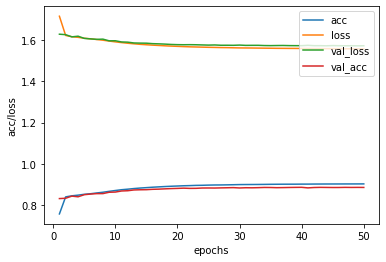

In [5]:
train_fn(50, 0.01, "SGD", net_1, "_without_maxpooling_")

Epoch: 1, loss: 1.562, acc: 0.901, val_loss: 1.492, val_acc: 0.968
Epoch: 2, loss: 1.489, acc: 0.973, val_loss: 1.492, val_acc: 0.968
Epoch: 3, loss: 1.482, acc: 0.979, val_loss: 1.484, val_acc: 0.975
Epoch: 4, loss: 1.478, acc: 0.984, val_loss: 1.483, val_acc: 0.976
Epoch: 5, loss: 1.477, acc: 0.984, val_loss: 1.483, val_acc: 0.975
Epoch: 6, loss: 1.477, acc: 0.985, val_loss: 1.480, val_acc: 0.978
Epoch: 7, loss: 1.474, acc: 0.988, val_loss: 1.483, val_acc: 0.975
Epoch: 8, loss: 1.473, acc: 0.989, val_loss: 1.481, val_acc: 0.977
Epoch: 9, loss: 1.472, acc: 0.989, val_loss: 1.482, val_acc: 0.976
Epoch: 10, loss: 1.471, acc: 0.990, val_loss: 1.482, val_acc: 0.977
Epoch: 11, loss: 1.472, acc: 0.990, val_loss: 1.478, val_acc: 0.980
Epoch: 12, loss: 1.470, acc: 0.991, val_loss: 1.480, val_acc: 0.978
Epoch: 13, loss: 1.470, acc: 0.991, val_loss: 1.478, val_acc: 0.981
Epoch: 14, loss: 1.470, acc: 0.991, val_loss: 1.479, val_acc: 0.979
Epoch: 15, loss: 1.469, acc: 0.992, val_loss: 1.480, val_

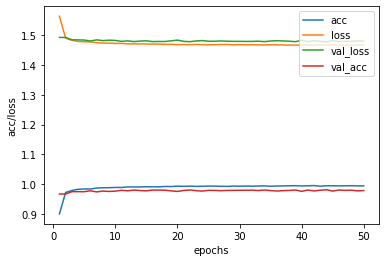

In [5]:
train_fn(50, 0.01, "Adam", net_2, "_with_maxpooling_")

Epoch: 1, loss: 1.871, acc: 0.592, val_loss: 1.693, val_acc: 0.768
Epoch: 2, loss: 1.673, acc: 0.790, val_loss: 1.604, val_acc: 0.860
Epoch: 3, loss: 1.567, acc: 0.899, val_loss: 1.508, val_acc: 0.956
Epoch: 4, loss: 1.499, acc: 0.966, val_loss: 1.495, val_acc: 0.967
Epoch: 5, loss: 1.491, acc: 0.973, val_loss: 1.494, val_acc: 0.966
Epoch: 6, loss: 1.487, acc: 0.977, val_loss: 1.492, val_acc: 0.968
Epoch: 7, loss: 1.484, acc: 0.978, val_loss: 1.488, val_acc: 0.972
Epoch: 8, loss: 1.482, acc: 0.981, val_loss: 1.490, val_acc: 0.970
Epoch: 9, loss: 1.480, acc: 0.982, val_loss: 1.485, val_acc: 0.975
Epoch: 10, loss: 1.478, acc: 0.984, val_loss: 1.486, val_acc: 0.973
Epoch: 11, loss: 1.478, acc: 0.984, val_loss: 1.486, val_acc: 0.973
Epoch: 12, loss: 1.476, acc: 0.986, val_loss: 1.485, val_acc: 0.974
Epoch: 13, loss: 1.475, acc: 0.987, val_loss: 1.485, val_acc: 0.974
Epoch: 14, loss: 1.475, acc: 0.987, val_loss: 1.486, val_acc: 0.973
Epoch: 15, loss: 1.474, acc: 0.988, val_loss: 1.485, val_

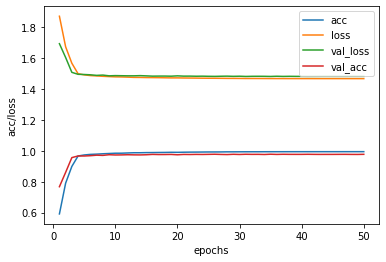

In [5]:
train_fn(50, 0.01, "SGD", net_2, "_with_maxpooling_")

Epoch: 1, loss: 1.587, acc: 0.876, val_loss: 1.505, val_acc: 0.956
Epoch: 2, loss: 1.492, acc: 0.970, val_loss: 1.486, val_acc: 0.973
Epoch: 3, loss: 1.486, acc: 0.975, val_loss: 1.486, val_acc: 0.973
Epoch: 4, loss: 1.483, acc: 0.978, val_loss: 1.487, val_acc: 0.972
Epoch: 5, loss: 1.482, acc: 0.980, val_loss: 1.486, val_acc: 0.973
Epoch: 6, loss: 1.479, acc: 0.982, val_loss: 1.485, val_acc: 0.973
Epoch: 7, loss: 1.478, acc: 0.984, val_loss: 1.481, val_acc: 0.977
Epoch: 8, loss: 1.476, acc: 0.985, val_loss: 1.489, val_acc: 0.970
Epoch: 9, loss: 1.476, acc: 0.985, val_loss: 1.484, val_acc: 0.975
Epoch: 10, loss: 1.475, acc: 0.986, val_loss: 1.480, val_acc: 0.979
Epoch: 11, loss: 1.475, acc: 0.986, val_loss: 1.481, val_acc: 0.977
Epoch: 12, loss: 1.475, acc: 0.986, val_loss: 1.482, val_acc: 0.976
Epoch: 13, loss: 1.473, acc: 0.988, val_loss: 1.480, val_acc: 0.979
Epoch: 14, loss: 1.473, acc: 0.989, val_loss: 1.481, val_acc: 0.978
Epoch: 15, loss: 1.473, acc: 0.988, val_loss: 1.483, val_

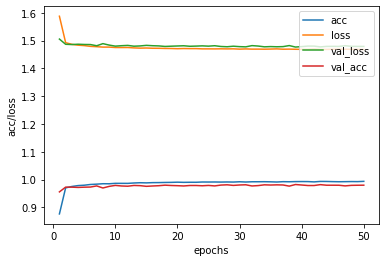

In [5]:
train_fn(50, 0.01, "Adam", net_3, "_with_maxpooling_with_dropout_")

Epoch: 1, loss: 1.758, acc: 0.707, val_loss: 1.625, val_acc: 0.836
Epoch: 2, loss: 1.625, acc: 0.838, val_loss: 1.603, val_acc: 0.856
Epoch: 3, loss: 1.609, acc: 0.854, val_loss: 1.595, val_acc: 0.865
Epoch: 4, loss: 1.597, acc: 0.866, val_loss: 1.587, val_acc: 0.874
Epoch: 5, loss: 1.590, acc: 0.872, val_loss: 1.581, val_acc: 0.878
Epoch: 6, loss: 1.584, acc: 0.877, val_loss: 1.579, val_acc: 0.880
Epoch: 7, loss: 1.582, acc: 0.880, val_loss: 1.576, val_acc: 0.883
Epoch: 8, loss: 1.580, acc: 0.882, val_loss: 1.574, val_acc: 0.885
Epoch: 9, loss: 1.578, acc: 0.883, val_loss: 1.574, val_acc: 0.884
Epoch: 10, loss: 1.576, acc: 0.885, val_loss: 1.573, val_acc: 0.885
Epoch: 11, loss: 1.575, acc: 0.886, val_loss: 1.573, val_acc: 0.886
Epoch: 12, loss: 1.574, acc: 0.887, val_loss: 1.572, val_acc: 0.885
Epoch: 13, loss: 1.573, acc: 0.887, val_loss: 1.571, val_acc: 0.888
Epoch: 14, loss: 1.572, acc: 0.888, val_loss: 1.571, val_acc: 0.887
Epoch: 15, loss: 1.572, acc: 0.889, val_loss: 1.571, val_

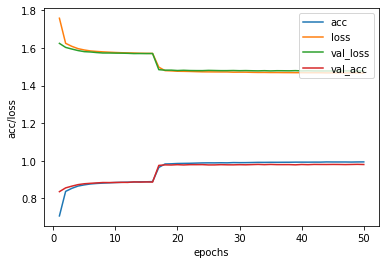

In [10]:
train_fn(50, 0.01, "SGD", net_3, "_with_maxpooling_with_dropout_")